In [1]:
import itertools
import os
import random
import time

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy
import scipy.stats as st
import torch
import torch_geometric
from scipy.io import mmread
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score

## More resources
- [Good series on Graph neural networks](https://antoniolonga.github.io/Pytorch_geometric_tutorials/index.html)


# Data handling

In [2]:
from torch_geometric.data import Batch, Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.utils import from_networkx, to_networkx

## Data class

[About PyG](https://www.youtube.com/watch?v=NKZdqCi5fVE&t=4339s)

Pytorch models graphs using the `Data` class. Given a graph with features $G = (X_n, (I, X_e))$ where 
- $X_n \in \mathbb R^{|V| \times d_n}$ are node features of dimension $d_n$, 
- $X_e \in \mathbb R^{|E| \times d_e}$ are edge features of dimension $d_e$, and 
- $I \in \mathbb R^{2 \times |E|}$ are the edge indices.   

The data object keeps these features in the following format:

- `data.x`: Node feature matrix with shape `[num_nodes, num_node_features]`
- `data.edge_index`: Graph connectivity in COO format with shape `[2, num_edges]` and type `torch.long`
- `data.edge_attr`: Edge feature matrix with shape `[num_edges, num_edge_features]`
- `data.y`: Target to train against (may have arbitrary shape), e.g., node-level targets of shape `[num_nodes, *]` or graph-level targets of shape `[1, *]`
- `data.pos`: Node position matrix with shape `[num_nodes, num_dimensions]`

**COO format**
`edge_index` -- COO format (coordinate format) commonly used for representing sparse matrices. Instead of holding the adjacency information in a dense representation $A \in \{0,1\}^{|V|\times|V|}$, PyG represents graphs sparsely, which refers to only holding the coordinates/values for which entries in $A$ are **non-zero**.


In [5]:
# ?Data

Let's make the following graph

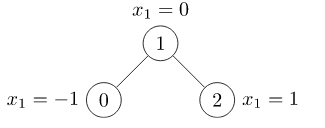

In [3]:
# edges -- both directions
edge_index = torch.tensor([[0, 1, 1, 2], [1, 0, 2, 1]], dtype=torch.long)
print(edge_index)
print(edge_index.shape)

tensor([[0, 1, 1, 2],
        [1, 0, 2, 1]])
torch.Size([2, 4])


In [4]:
# node feature map

x = torch.tensor([[-1], [0], [1]], dtype=torch.float)
print(x)
print(x.shape)

tensor([[-1.],
        [ 0.],
        [ 1.]])
torch.Size([3, 1])


In [5]:
data = Data(x=x, edge_index=edge_index)
print(data)

Data(x=[3, 1], edge_index=[2, 4])


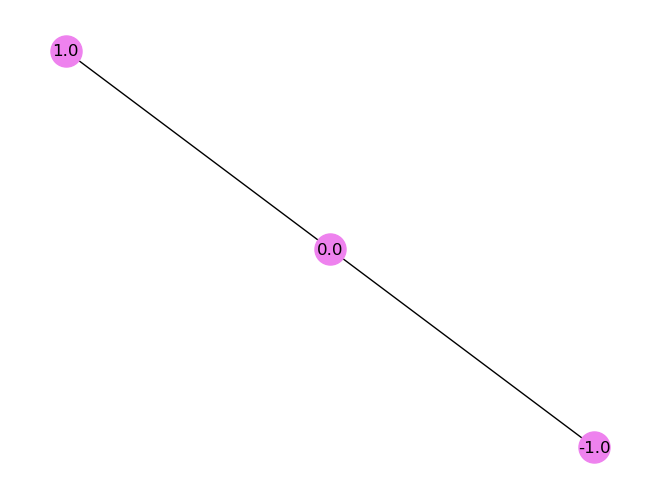

In [6]:
G = to_networkx(data, to_undirected=True)
nx.draw(
    G,
    with_labels=True,
    labels={u: x.item() for u, x in zip(G.nodes, data.x)},
    node_size=500,
    node_color="violet",
)

Note that `edge_index`, i.e. the tensor defining the source and target nodes of all edges, is not a list of index tuples. If you want to write your indices this way, you should transpose and call contiguous on it before passing them to the data constructor:

In [7]:
edge_index = torch.tensor([[0, 1], [1, 0], [1, 2], [2, 1]], dtype=torch.long)
data = Data(x=x, edge_index=edge_index.t().contiguous())

In [8]:
print("keys: ", data.keys)
print(data["x"])

keys:  ['x', 'edge_index']
tensor([[-1.],
        [ 0.],
        [ 1.]])


## Dataset, DataLoader, Batch

In [9]:
# ?Dataset
# ?DataLoader
# ?Batch

In [10]:
edge_index2 = torch.tensor([[0, 1], [1, 0]], dtype=torch.long)
x2 = torch.tensor([[-2], [2]], dtype=torch.float)
data2 = Data(x=x2, edge_index=edge_index2)

In [11]:
dataloader = DataLoader(
    [data, data2], batch_size=2
)  # Use dataloader like in pytorch

In [12]:
batch = next(iter(dataloader))
print(batch)
# Batch is a subclass of Data so the same methods can be used
print(isinstance(batch, Data))

DataBatch(x=[5, 1], edge_index=[2, 6], batch=[5], ptr=[3])
True


In [13]:
# You can index the batch to see the graphs contained
batch[0], batch[1]

(Data(x=[3, 1], edge_index=[2, 4]), Data(x=[2, 1], edge_index=[2, 2]))

In [14]:
# The .batch attribute contains the batch index for each node
batch.batch

tensor([0, 0, 0, 1, 1])

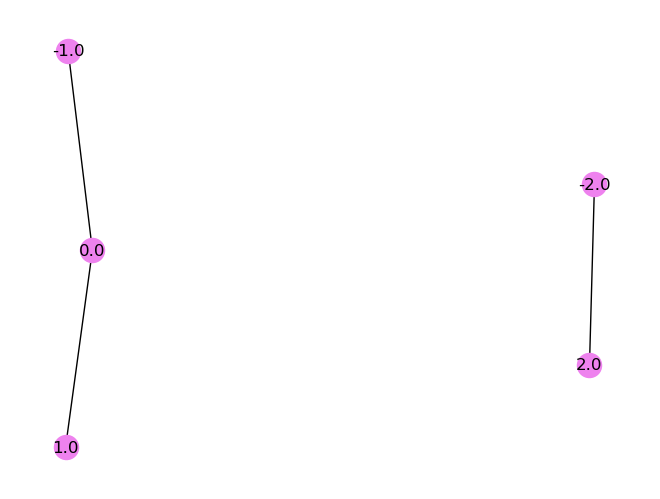

In [15]:
G = to_networkx(batch, to_undirected=True)
nx.draw(
    G,
    with_labels=True,
    labels={u: x.item() for u, x in zip(G.nodes, batch.x)},
    node_size=300,
    node_color="violet",
)

## karate-club

In [16]:
def print_dataset(dataset):
    print(f"Dataset: {dataset}:")
    print("======================")
    print(f"Number of graphs: {len(dataset)}")
    print(f"Number of features: {dataset.num_features}")
    print(f"Number of classes: {dataset.num_classes}")


def print_data(data):
    print(data)
    print("=" * 62)

    # Gather some statistics about the graph.
    print(f"Number of nodes: {data.num_nodes}")
    print(f"Number of edges: {data.num_edges}")
    print(f"Average node degree: {data.num_edges / data.num_nodes:.2f}")
    if hasattr(data, "train_mask"):
        print(f"Number of training nodes: {data.train_mask.sum()}")
        print(
            f"Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}"
        )
    print(f"Contains isolated nodes: {data.has_isolated_nodes()}")
    print(f"Contains self-loops: {data.has_self_loops()}")
    print(f"Is undirected: {data.is_undirected()}")

In [17]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print_dataset(dataset)

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


In [18]:
data = dataset[0]  # Get the first graph object.
print_data(data)

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


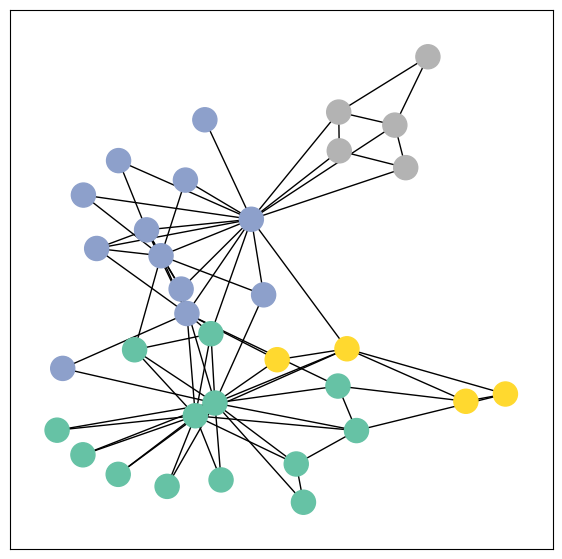

In [19]:
G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(7, 7))
nx.draw_networkx(
    G,
    pos=nx.spring_layout(G, seed=42),
    with_labels=False,
    node_color=data.y,
    cmap="Set2",
)
plt.show()

In [20]:
data2 = from_networkx(G)

In [21]:
data2  # Notice we lost the attributes. Inpsect ?to_networkx and ?from_networx to see why

Data(edge_index=[2, 156], num_nodes=34)

## TUDataset

In [22]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(
    root=os.path.join("..", "data", "tmp", "ENZYMES"), name="ENZYMES"
)

In [23]:
# Notice that this is a dataset with multiple graphs.

# Inpsect the dataset
print_dataset(dataset)
print()
# Inspect a graph
print_data(dataset[0])

Dataset: ENZYMES(600):
Number of graphs: 600
Number of features: 3
Number of classes: 6

Data(edge_index=[2, 168], x=[37, 3], y=[1])
Number of nodes: 37
Number of edges: 168
Average node degree: 4.54
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


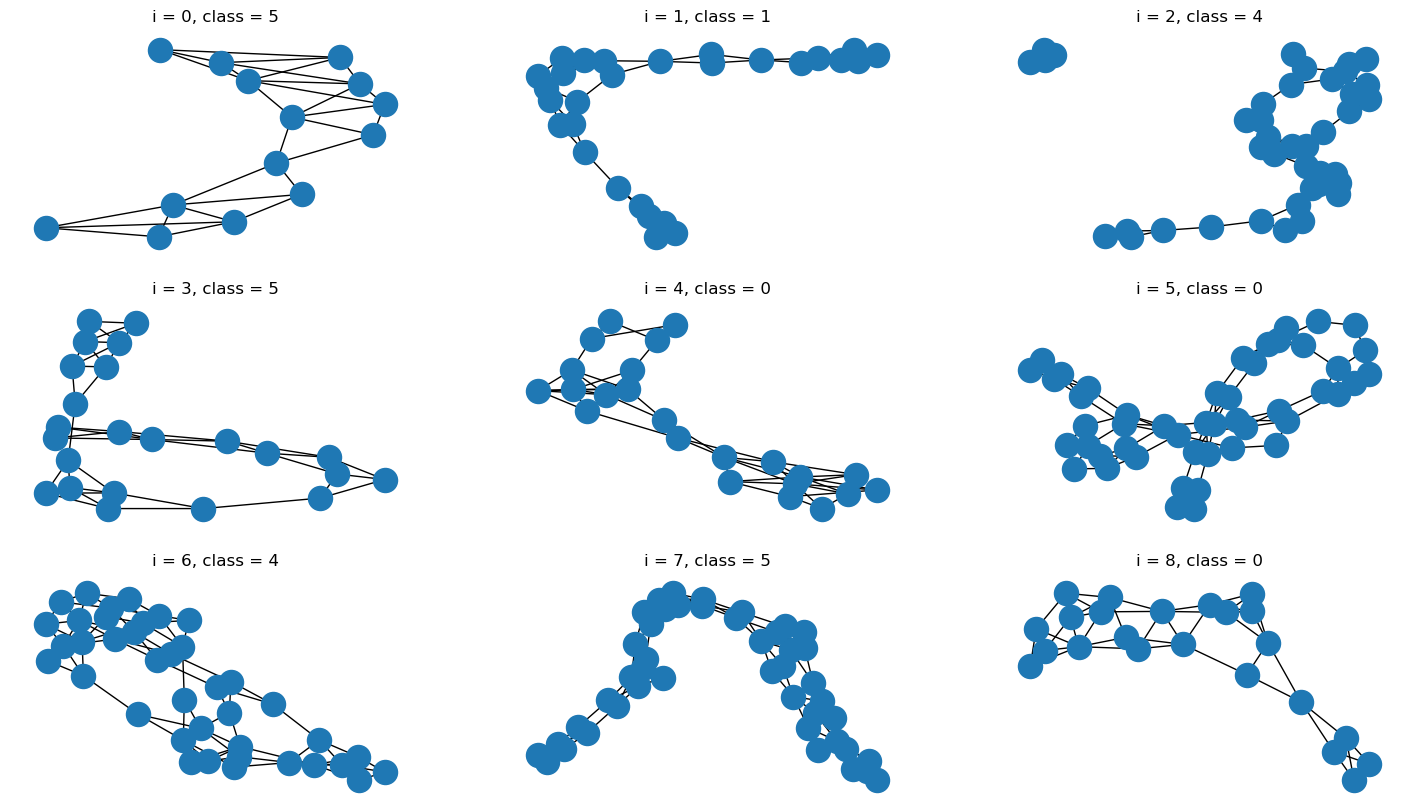

In [24]:
plt.figure(figsize=(18, 10))
for i, data in enumerate(dataset.shuffle()[:9]):
    plt.subplot(3, 3, i + 1)
    plt.title(f"{i = }, class = {int(data.y)}")
    G = to_networkx(data, to_undirected=True)
    nx.draw_spring(G)

## Cora dataset

- https://graphsandnetworks.com/the-cora-dataset/

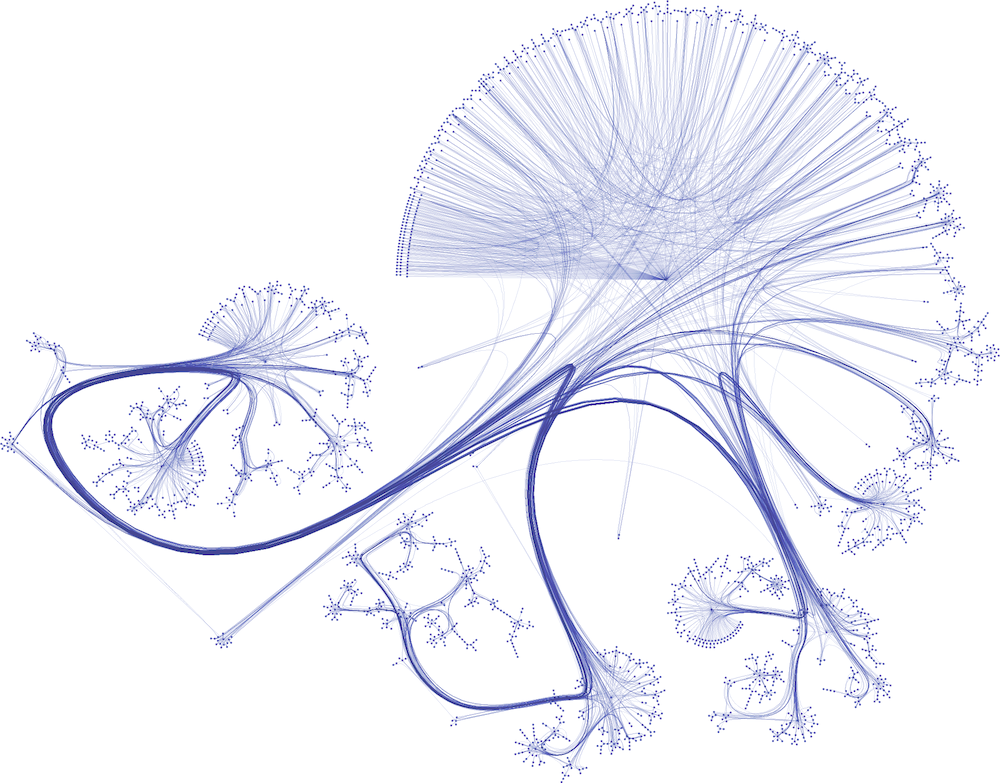

In [25]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root=os.path.join("..", "data", "tmp", "Cora"), name="Cora")

In [26]:
# This dataset has only 1 graph because it's a datase tfor semi-supervized *graph node classification*
print_dataset(dataset)
print()
print_data(dataset[0])

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [27]:
data = dataset[0]

# The train-val-test split is done with the train_mask, val_mask and test_mask attrs
print(data.train_mask, data.train_mask.sum().item())
print(data.val_mask, data.val_mask.sum().item())
print(data.test_mask, data.test_mask.sum().item())

tensor([ True,  True,  True,  ..., False, False, False]) 140
tensor([False, False, False,  ..., False, False, False]) 500
tensor([False, False, False,  ...,  True,  True,  True]) 1000


# Short example

Let's return to our karate graph

In [28]:
dataset = KarateClub()
data = dataset[0]
print_dataset(dataset)

data.test_mask = ~data.train_mask

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


In [29]:
data

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34], test_mask=[34])

Don't worry about the model, will be explained later

In [31]:
import torch
import torch.nn.functional as F
from torch import nn
from torch_geometric.nn import GCNConv
from torchinfo import summary

In [32]:
class MyGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, out_dim):
        super().__init__()
        torch.manual_seed(12345)
        # GCN layers
        self.conv1 = GCNConv(in_channels=input_dim, out_channels=hidden_dim)
        # Classifier layer
        # out_features should be the number of classes
        self.classifier = nn.Linear(
            in_features=hidden_dim, out_features=out_dim
        )
        # Transform into probabilities
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, edge_index):
        # Edge index is required for layers that look at graphs.

        h = self.conv1(x, edge_index)

        # Apply a final (linear) classifier.
        x = self.classifier(h)
        out = self.softmax(x)

        # `h` is the learned graph representation. We return it to look at it
        return out, h

In [33]:
model = MyGNN(
    input_dim=dataset.num_features, hidden_dim=8, out_dim=dataset.num_classes
)
summary(model)

Layer (type:depth-idx)                   Param #
MyGNN                                    --
├─GCNConv: 1-1                           8
│    └─SumAggregation: 2-1               --
│    └─Linear: 2-2                       272
├─Linear: 1-2                            36
├─Softmax: 1-3                           --
Total params: 316
Trainable params: 316
Non-trainable params: 0

Embedding shape: [34, 8]


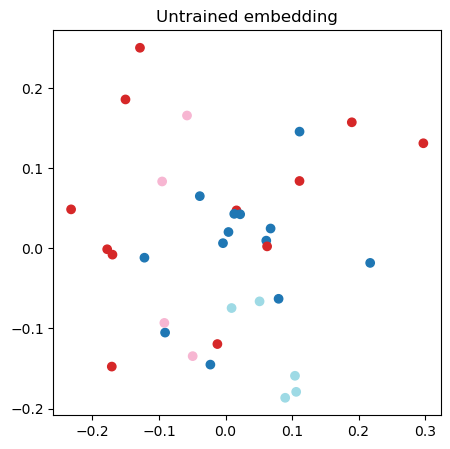

In [34]:
_, h = model(data.x, data.edge_index)
print(f"Embedding shape: {list(h.shape)}")

plt.figure(figsize=(5, 5))
plt.title("Untrained embedding")
plt.scatter(
    *PCA(n_components=2).fit_transform(h.cpu().detach().numpy()).T,
    c=data.y,
    cmap=plt.cm.tab20,
)
# plt.scatter(*h.detach().T, c = data.y, cmap = "Set2", s = 100)
plt.show()

In [36]:
model = MyGNN(
    input_dim=dataset.num_features, hidden_dim=8, out_dim=dataset.num_classes
)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

In [37]:
def train(model, data, optimizer, criterion):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(
        out[data.train_mask], data.y[data.train_mask]
    )  # Compute the loss solely based on the training nodes.

    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss.item(), h


@torch.no_grad()
def test(model, data, mask, criterion):
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[mask], data.y[mask])

    return loss.item(), accuracy_score(
        data.y[mask], np.argmax(out[mask].detach().numpy(), axis=1)
    )

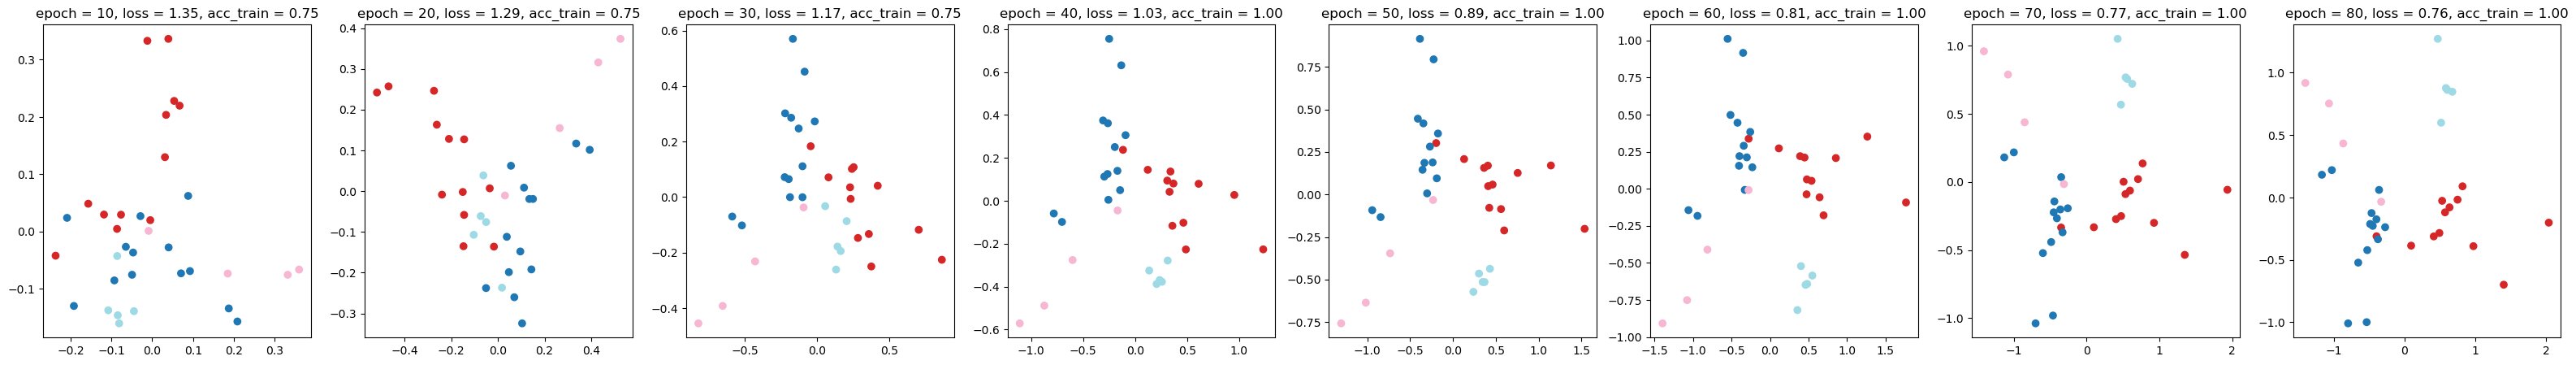

In [38]:
fig, axs = plt.subplots(1, 8, figsize=(8 * 5, 5))
for epoch in range(1, 81):
    loss, h = train(model, data, optimizer, criterion)
    loss_train, acc_train = test(model, data, data.train_mask, criterion)
    if epoch % 10 == 0:
        i = epoch // 10 - 1
        axs[i].set_title(f"{epoch = }, {loss = :.2f}, {acc_train = :.2f}")
        axs[i].scatter(
            *PCA(n_components=2).fit_transform(h.cpu().detach().numpy()).T,
            c=data.y,
            cmap=plt.cm.tab20,
        )
plt.show()

In [39]:
out, h = model(data.x, data.edge_index)
out = out[data.test_mask]

In [40]:
(torch.sum(torch.argmax(out, axis=1) == data.y[data.test_mask]) / torch.sum(
    data.test_mask
)).item()

0.8333333134651184